# Welcome to the 2020 Low Flow Data Processing Script.
***
#### click in cell and then alt+Enter to execute
#### Follow through the steps below to produce wonderfully accurate and high quality flow data
#### Enjoy!

In [1]:
#!jt -t onedork

In [2]:
## Data Directories (will hopefully replace with a database soon)
maindir = 'C:/Users/alex.messina/Documents/GitHub/2020_County_LowFlow/'
import os
os.chdir('C:/Users/alex.messina/Documents/GitHub/2020_County_LowFlow/Python_code/')

In [3]:
## Import Standard modules
import pandas as pd
import datetime as dt
import string
import textwrap
import numpy as np
import calendar
from scipy import signal
## Plotting modules
import matplotlib as mpl
from matplotlib import pyplot as plt
## Jupyter interactive plots
import mpld3
#mpld3.enable_notebook()
## for Zentra API
from pytz import timezone
import json
import urllib2
## for OneRain data getter 
import requests
import time
from BeautifulSoup import BeautifulSoup
## Get google sheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g 
## Image tools
import matplotlib.image as mpimg
from scipy import ndimage
from PIL import Image
## Path to Custom modules
import sys
sys.path.append('..')
# Import Custom Modules
from ZentraAPI import *
from Get_GoogleSheets import *
from OneRain_data import *
from Excel_Plots import Excel_Plots    
from OvertoppingFlows import *
from hover_points import *
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>    div#notebook-container    { width: 95%; }    div#menubar-container    
{ width: 80%; }    div#maintoolbar-container { width: 99%; } </style> """))       
## Display outputs side by side
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))
## Open HvF table - can be Google Sheets or straight from GitHub?
#HvF = pd.read_csv(maindir+'Ancillary_files/HvF-90degweir.csv',index_col='Level (in)') # Local file
#Hvf = open_HvF_90degweir()  # Google Sheets
HvF = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/HvF-90degweir.csv',index_col=0) # GitHub
## WEIR DIMENSIONS FOR OVERTOPPING FLOWS - can be Google Sheets or straight from GitHub?
#weir_dims = pd.read_excel(maindir+'Ancillary_files/Weir Dims 2020.xlsx',sheetname='2020',index_col='Site',skiprows=1, parse_cols='A:I',na_values=['Not Applicable']) # Local file
#weir_dims = open_weir_dims() # Google Sheets
weir_dims = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Weir_Dims_2020.csv',index_col=0) # GitHub

print "All modules imported. Let's go!"

All modules imported. Let's go!


## Define site name and start/end times
***

In [4]:
## Update the Site Name and start/end times
site_name = 'CAR-007'
start_time_loc = dt.datetime(2020,5,1,0,0)
end_time_loc = dt.datetime(2020,5,15,0,0)

## Water Level Data
***
#### from Local file or GitHub
#### original data is batch downloaded from Zentra via the ZentraAPI

In [5]:
## FROM CSV
## If data is already downloaded, load from csv
#WL = pd.DataFrame.from_csv(maindir+'Water_Level_data/'+site_name+'raw_data_ZentraAPI.csv') # Local file
WL = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Water_Level_data/'+site_name+'_raw_data_ZentraAPI.csv') # GitHub
## Inspect the data from Zentra to make sure it looks right...
WL.ix[start_time_loc:end_time_loc]

,in Water Level,°F Water Temperature,mS/cm EC,Sensor Metadata,% Battery Percent,mV Battery Voltage,kPa Reference Pressure,°F Logger Temperature
2020-05-01 00:00:00,3.18897,67.640,7.345139,0.0,100,7568,101.17,70.160
2020-05-01 00:05:00,3.18897,67.640,7.362071,0.0,98,7462,101.16,70.502
2020-05-01 00:10:00,3.18897,67.640,7.362071,0.0,98,7450,101.17,70.934
2020-05-01 00:15:00,3.22834,67.640,7.362071,0.0,97,7436,101.16,71.222
2020-05-01 00:20:00,3.22834,67.640,7.345139,0.0,100,7530,101.17,71.096
2020-05-01 00:25:00,3.26771,67.640,7.345139,0.0,100,7534,101.17,70.844
2020-05-01 00:30:00,3.22834,67.640,7.345139,0.0,100,7537,101.18,70.700
2020-05-01 00:35:00,3.26771,67.640,7.362071,0.0,100,7539,101.18,70.592
2020-05-01 00:40:00,3.26771,67.640,7.362071,0.0,100,7542,101.19,70.538
2020-05-01 00:45:00,3.26771,67.568,7.396053,0.0,100,7542,101.19,70.502


## Daily Rain data
***

In [6]:
## Get the rain gauge used for the site
#rain_gauge_site_list = pd.DataFrame.from_csv(maindir+'Ancillary_files/Rain_gauge_to_sites_list.csv') # Local File
rain_gauge_site_list = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Rain_gauge_to_sites_list.csv',index_col=0) # GitHub
rain_gauge_name = rain_gauge_site_list.ix[site_name]['rain_gauge_name']
print 'Rain gauge used for '+site_name+' is '+ rain_gauge_name
## Rain gauges indexed by rain gauge name
#Rain_gauge_info = pd.DataFrame.from_csv(maindir+'Ancillary_files/Rain_gauge_info.csv') # Local File
Rain_gauge_info = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Rain_gauge_info.csv',index_col=0) # GitHub
start_date, end_date = start_time_loc.strftime('%Y-%m-%d'), end_time_loc.strftime('%Y-%m-%d')
Rain1D = pd.DataFrame.from_csv(maindir+'Rain_data/'+rain_gauge_name+'_daily_'+start_date+'-'+end_date+'.csv') # Local file
Rain1D = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Rain_data/'+rain_gauge_name+'_daily_'+start_date+'-'+end_date+'.csv') # GitHub
## Check output 
Rain1D


Rain gauge used for CAR-007 is El Camino del Norte


# Offsetting/Calibrating Water Level Data
***
1. Apply special offsets and clip bad data (storms will be clipped later)
2. Calculate and apply offset from calibration points 
3. global offset to manually adjust
#### >>> FINAL OFFSET saved to Google Sheets
####  
### 1a. Special Offsets
***

Special offsets from Google sheet: 
Special offset: 05/01/20 00:00 - 05/04/20 00:00 = 0 inches



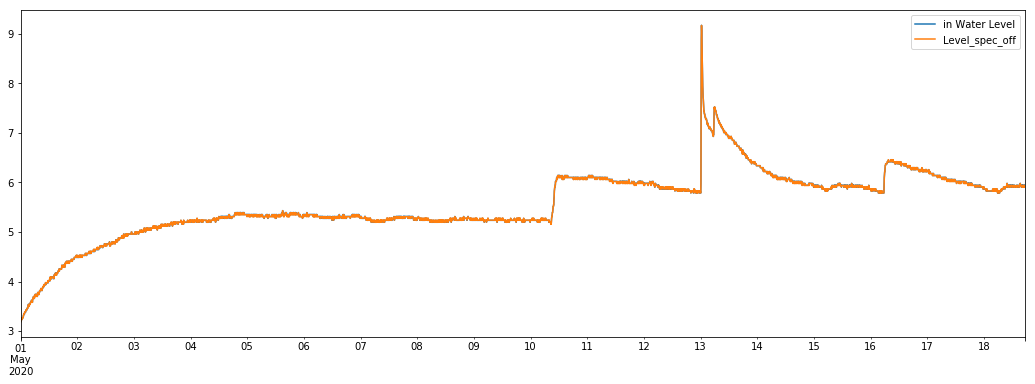

In [8]:
## Add column of zero for data offset
WL['spec_offset'] = 0.
## Special Offsets and Bad Data Clips, Global Offset from Google Sheets
spec_offsets  = open_2020_ClipsOffsets()[0]
## Get offsets for each site
offsets_list_for_site = spec_offsets[spec_offsets.index  == site_name]
offsets_list_for_site
## THIS IS AS TUPLES SO THE TUPLE IS INDEXED BY NUMBER NOT STRING
for spec_offset in offsets_list_for_site.itertuples():
    print ('Special offsets from Google sheet: ')
    #print offset
    ## set data in bad_data indices to nan
    if pd.notnull(spec_offset.Start)==True and pd.notnull(spec_offset.End)==True:
        print ('Special offset: '+spec_offset.Start.strftime('%m/%d/%y %H:%M')+' - '+spec_offset.End.strftime('%m/%d/%y %H:%M')+' = '+str(spec_offset.SpecialOffset_in)+ ' inches')
        ## insert each offset value to Offset column
        WL.loc[spec_offset.Start:spec_offset.End, ['spec_offset']] = spec_offset.SpecialOffset_in
    else:
        pass
    print ('')   
## Apply all offsets for unique shifts due to bad data or other issues
WL['Level_spec_off'] = WL['in Water Level'] + WL['spec_offset']
WL['Level_spec_off'] = WL['Level_spec_off'].round(2)
WL[['in Water Level','spec_offset','Level_spec_off']].head()
WL[['in Water Level','Level_spec_off']].plot(figsize=(18,6))

### 1b. Clip bad data (don't want it used with Field Measurements)

Clipping bad/invalid data....
Clipped Invalid data from: 05/01/20 00:00-05/01/20 00:00


,Site,Start,End,Reason,Notes,Analyst
Site,,,,,,
CAR-007,CAR-007,2020-05-01,2020-05-01,Invalid,NaN,NaN


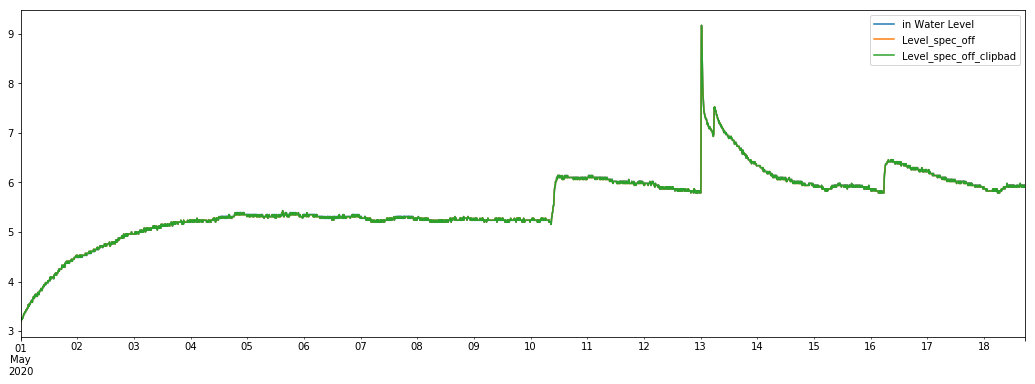

In [9]:
clips =  open_2020_ClipsOffsets()[2]

try: # one entry dataframes are weird
    clips_for_site = pd.DataFrame(clips.loc[site_name,:])
    bad_data_clips = clips_for_site[clips_for_site['Reason']=='Invalid']
except:
    clips_for_site = pd.DataFrame(clips.loc[site_name,:]).T # have to make DF and Transpose it 
    bad_data_clips = clips_for_site[clips_for_site['Reason']=='Invalid']    
## iterate over list of bad data and clip from 'offset_flow_clipped'....
print ('Clipping bad/invalid data....')
WL['Level_spec_off_clipbad'] = WL['Level_spec_off']
for clip in bad_data_clips.iterrows():
    clip_start, clip_end = clip[1]['Start'], clip[1]['End']
    if pd.isnull(clip_start)==False and pd.isnull(clip_end) == False:
        print ('Clipped Invalid data from: '+clip_start.strftime('%m/%d/%y %H:%M')+'-'+clip_end.strftime('%m/%d/%y %H:%M'))
        ## set data in WL indices to nan
        WL.loc[clip_start:clip_end, ['Level_spec_off_clipbad']] = np.nan
    else:
        print ('No data to clip...')
        pass   
WL[['in Water Level','Level_spec_off','Level_spec_off_clipbad']].plot(figsize=(18,6))
bad_data_clips

## 2. Calculate offset from calibration measurements
### Field Data for Calibrations
### Load from Google Sheets or csv if already saved
***

In [10]:
## Open FDS from Google Sheets
fds = open_fds_from_google_sheet()
## Save to csv
fds.to_csv(maindir+'Ancillary_files/FDS/Field_data_sheet_backup.csv',encoding='utf-8')


Dropped 0 duplicate rows



c:\spyder-master\python-2.7.10.amd64\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


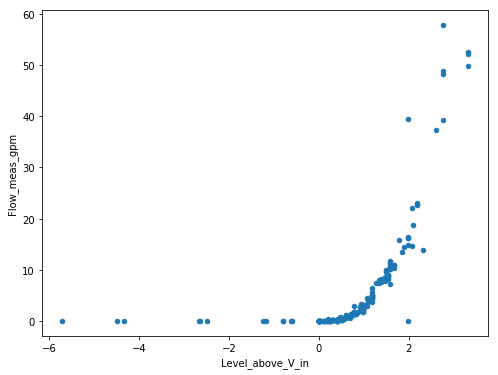

In [11]:
## Load from csv
fds = pd.DataFrame.from_csv(maindir+'Ancillary_files/FDS/Field_data_sheet_backup.csv')
## Round to 5Min
fds['Datetime'] = pd.to_datetime(fds['Date and Time']).apply(lambda x: dt.datetime(x.year, x.month, x.day, x.hour,5*(x.minute // 5)))
## Make Index line up with Excel row numbers for easy reference
fds.index+=2
## Drop any duplicate rows so it doesn't weight the average 
fds_len =  len(fds)
fds = fds.drop_duplicates(keep='first')
fds_len_no_dup = len(fds)
diff = fds_len - fds_len_no_dup
print ('')
print ('Dropped '+str(diff)+' duplicate rows')
print ('')
## strip commas from volume measurement
fds['Flow Measurement, Volume in mL'] = fds['Flow Measurement, Volume in mL'].apply(lambda x: x.replace(',',''))
## cm to inches
fds['Level_above_V_cm'] = fds['Height above (+) or below (-) v-notch in cm']
fds['Level_above_V_in'] = np.round(fds['Level_above_V_cm'] / 2.54, 2)
## Flow in cfs: mL to cfs divided by seconds
fds['Flow_meas_gpm'] = (fds['Flow Measurement, Volume in mL'].astype('float') / fds['Flow Measurement, Time in Seconds '].astype('float')) * 0.02 #1mL per second is 0.02 gpm
fds['Flow_meas_gpm'] = fds['Flow_meas_gpm'].round(3)
## Display measurements
fds[['Site ID','Datetime','Level_above_V_in','Flow_meas_gpm']].head()
fds[['Level_above_V_in','Flow_meas_gpm']].plot.scatter('Level_above_V_in','Flow_meas_gpm',figsize=(8,6))
#fds[['Site ID','Datetime','Date and Time','Flow Condition',u'NOTES',u'Site Photo or Video?', u'Height above (+) or below (-) v-notch in cm',u'Flow Measurement, Time in Seconds ',u'Flow Measurement, Volume in mL']]

### Calculate Offset from Calibration Points for Site

Field measurement time:2020-05-05 14:00:00
Level data from Meter: 
5.35
Field measurement time:2020-05-15 14:05:00
Level data from Meter: 
5.94
Field measurement time:2020-05-19 12:00:00
Level data from Meter: 


,Datetime,Level_above_V_in,Level_spec_off_clipbad,Predicted_flow
31,2020-05-05 14:00:00,-1.25,5.35,0.0
147,2020-05-15 14:05:00,-0.63,5.94,0.0
176,2020-05-19 12:00:00,-0.79,NaN,0.0


,Datetime,Flow_meas_gpm
31,2020-05-05 14:00:00,0.0
147,2020-05-15 14:05:00,0.0
176,2020-05-19 12:00:00,0.0


Calculated offset = -6.6 in


c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


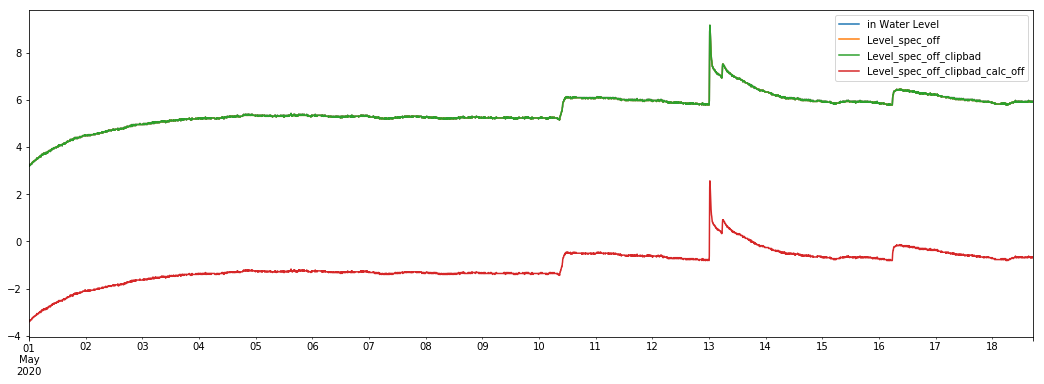

In [12]:
## Choose time for selecting points
cal_start, cal_end = start_time_loc, end_time_loc
# FIELD MEASUREMENTS
field_meas_level = fds[fds['Site ID']==site_name][['Datetime','Level_above_V_in']]
field_meas_flow = fds[fds['Site ID']==site_name][['Datetime','Flow_meas_gpm']]
## Add PT level data to field measured level 
for t in field_meas_level['Datetime'].values:
    t = pd.to_datetime(t)
    print ('Field measurement time:' + str(t))
    try:
        print 'Level data from Meter: '
        print WL.loc[t]['Level_spec_off_clipbad'] ## water level after manual offset
        field_meas_level.loc[field_meas_level['Datetime']==t, 'Level_spec_off_clipbad'] = WL.loc[t]['Level_spec_off_clipbad']
    except:
        try:
            ' Shifting calibration time back 5 miutes....'
            t = t - dt.timedelta(minutes=5)
            field_meas_level.loc[field_meas_level['Datetime']==t, 'Level_in'] = WL.loc[t]['Level_in']
        except:
            pass
## Add the flow that would be predicted from v-notch equation
try: 
    field_meas_level.loc[:,'Predicted_flow'] =  [HvF.loc[np.round(x,2)]['Q (GPM)'] for x in field_meas_level['Level_above_V_in'].values]
except KeyError:
    #field_meas_level_nozeros = field_meas_level[field_meas_level['Level_above_V_in'] >=0.]
    #field_meas_level_nozeros.loc['Predicted_flow'] = 0.
    field_meas_level.loc[:,'Predicted_flow'] = 0.
## Display field measurements of level and flow 
display(field_meas_level, field_meas_flow)
## Calibration measurements made in May, QC measurements made June-Sept
field_meas_level_QC = field_meas_level[field_meas_level['Datetime']>cal_end] ## after 5/31 should be only QC measurements
field_meas_level_Cal = field_meas_level[(field_meas_level['Datetime']>=cal_start) & (field_meas_level['Datetime']<=cal_end)]
field_meas_flow_QC =  field_meas_flow[field_meas_flow['Datetime']>cal_end] ## after 5/31 should be only QC measurements
field_meas_flow_Cal =  field_meas_flow[(field_meas_flow['Datetime']>=cal_start) & (field_meas_flow['Datetime']<=cal_end)]
## Calculate average offset from field data
field_meas_level_Cal['calculated offset'] = field_meas_level_Cal['Level_above_V_in'] - field_meas_level_Cal['Level_spec_off_clipbad'] ## Measured - Manually adjusted PT reading
## Calculate total offset  
calculated_offset = field_meas_level_Cal['calculated offset'].mean()
print 'Calculated offset = '+str(calculated_offset)+' in'
## Copy over data that has already had special offsets applied and bad data clipped
## Apply calculated offset
WL['Level_spec_off_clipbad_calc_off'] = WL['Level_spec_off_clipbad'] + calculated_offset
## Display water level data
WL[['in Water Level','Level_spec_off','Level_spec_off_clipbad','Level_spec_off_clipbad_calc_off']].plot(figsize=(18,6))

### 3. Apply Global Offset
***

Global offset for CAR-007 = 0 in.


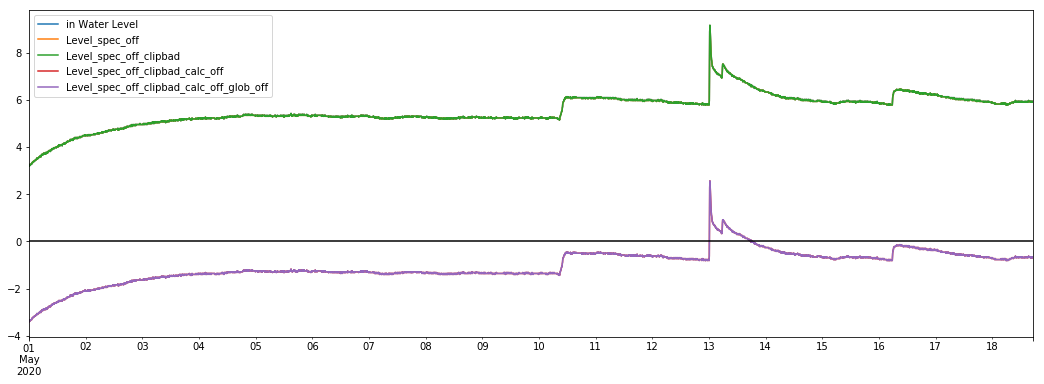

In [13]:
## Get global offset (stored in Google Sheets)
glob_offsets = open_2020_ClipsOffsets()[1]
glob_offset = glob_offsets.ix[site_name]['GlobalOffset_in']
print 'Global offset for '+site_name+' = '+str(glob_offset) +' in.'
## Apply global offset
WL['Level_spec_off_clipbad_calc_off_glob_off'] = WL['Level_spec_off_clipbad_calc_off'] + glob_offset
## Final, offset and cleaned water level data for flow calculation
WL['Level_in'] = WL['Level_spec_off_clipbad_calc_off_glob_off']
## Highlight missing data  
missing_data = pd.DataFrame(WL[np.isnan(WL['Level_in'])]['Level_in'])
missing_data['missing_level_data'] = 0.
missing_data = missing_data.reindex(index=pd.date_range(start_time_loc,end_time_loc,freq='5Min'))
## Display water level data
ax = WL[['in Water Level','Level_spec_off','Level_spec_off_clipbad','Level_spec_off_clipbad_calc_off','Level_spec_off_clipbad_calc_off_glob_off']].plot(figsize=(18,6))
ax.axhline(0,c='k')

### Save Total offset
#### >>> Saved in Google Sheets
***

In [14]:
FinalOffsets = open_2020_FinalOffsets()
FinalOffsets = FinalOffsets[['CalculatedOffset_in','GlobalOffset_in','FinalOffset_in']]
FinalOffsets.loc[site_name,'CalculatedOffset_in'] = calculated_offset
FinalOffsets.loc[site_name,'GlobalOffset_in'] = glob_offset
FinalOffset = calculated_offset + glob_offset
FinalOffsets.loc[site_name,'FinalOffset_in'] = FinalOffset
save_df_to_GoogleSheets(FinalOffsets, worksheet_name='FinalOffsets',spreadsheet_key="1U0UnBJrpMNEtDYctO2GW0fuobdc8vJfdLIWbvSr--ss")
FinalOffsets.to_csv(maindir+'Ancillary_files/FinalOffsets_backup.csv')
## Display
FinalOffsets.ix[site_name]

CalculatedOffset_in   -6.6
GlobalOffset_in          0
FinalOffset_in        -6.6
Name: CAR-007, dtype: object

## Calculate Flow
### HvF table for 90deg v-notch until water level exceeds v, then CTRSC equation
****

In [15]:
weir_dims
vnotch_in= float(weir_dims.ix[site_name][['h2']].values[0])
vnotch_in

4.0

4.0 8.0 11.5 8.25 8.0 1.0


OvertoppingFlows.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Level_in'] = df['Level_in'].where(df['Level_in'] >= 0., np.nan)
OvertoppingFlows.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['h2(m)'] = df['Level_in'] * 0.0254 ## Height above V
OvertoppingFlows.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

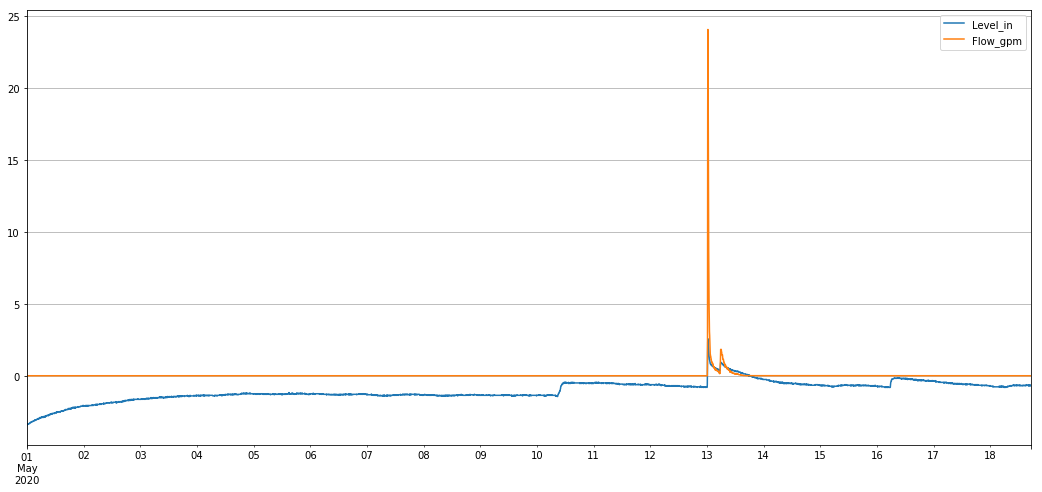

In [16]:
## HvF table for 90 deg v-notch
def level_to_gpm_vnotch(x):
    if x < 0:
        gpm = 0.0
    else:
        gpm = HvF.loc[np.round(x,2)]['Q (GPM)']
    return gpm
WL['Flow_gpm_v'] = WL['Level_in'].apply(lambda x: level_to_gpm_vnotch(x))    
## Calculate flows when overtopping the weir
WL['Flow_gpm'] = CTRSC_compound_weir(site_name, WL, weir_dims)#,  True, True)
WL[['Level_in','Flow_gpm']].plot(figsize=(18,8),grid=True)

## QC Hydrograph and Clip storm flow
***

Clipping stormflow data....
Clipped storm data from: 05/01/20 00:00-05/01/20 00:00


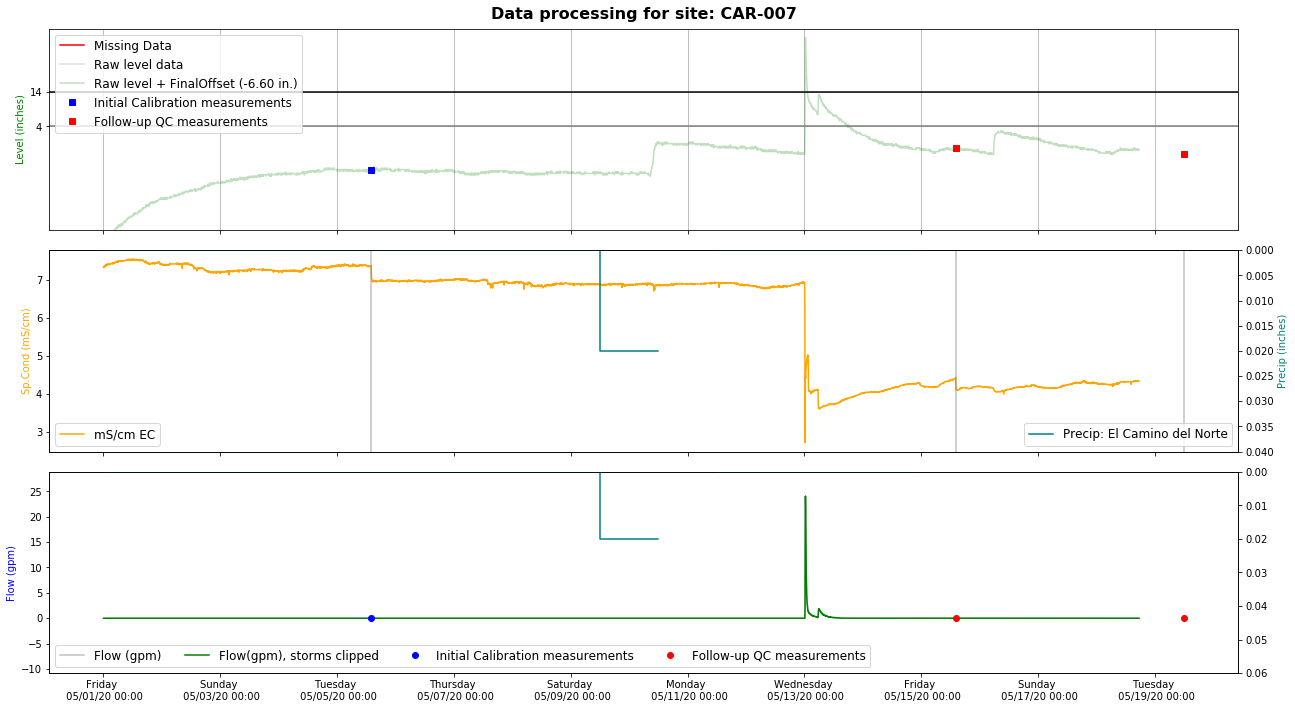

In [17]:
## Clip storm flows
clips =  open_2020_ClipsOffsets()[2] # reload every time so Google sheet can be updated
try: # one entry dataframes are weird
    clips_for_site = pd.DataFrame(clips.loc[site_name,:])
    storm_clips = clips_for_site[clips_for_site['Reason']=='Storm']
except:
    clips_for_site = pd.DataFrame(clips.loc[site_name,:]).T # have to make DF and Transpose it 
    storm_clips = clips_for_site[clips_for_site['Reason']=='Storm']    
## iterate over list of bad data and clip from 'Flow_gpm'....
print ('Clipping stormflow data....')
WL['Flow_gpm_storm_clipped'] = WL['Flow_gpm']
for clip in storm_clips.iterrows():
    clip_start, clip_end = clip[1]['Start'], clip[1]['End']
    if pd.isnull(clip_start)==False and pd.isnull(clip_end) == False:
        print ('Clipped storm data from: '+clip_start.strftime('%m/%d/%y %H:%M')+'-'+clip_end.strftime('%m/%d/%y %H:%M'))
        ## set data in WL indices to nan
        WL.loc[clip_start:clip_end, ['Flow_gpm_storm_clipped']] = np.nan
    else:
        print ('No data to clip...')
        pass   
storm_clips

########################################
##### QC Hydrograph ###################
#####################################
fig, (ax1, ax2, ax4) = plt.subplots(3,1,figsize=(18,10),sharex=True)
## Plot full scale level data
ax1.plot_date(missing_data.index,missing_data['missing_level_data'],marker='None',ls='-',c='r',label='Missing Data')
## raw
ax1.plot_date(WL.index, WL['in Water Level'], marker='None',ls='-',c='grey',alpha=0.25,label='Raw level data')
##raw +final offset
ax1.plot_date(WL.index, WL['Level_in'], marker='None',ls='-',c='g',alpha=0.25,label='Raw level + FinalOffset ('+"%.2f"%FinalOffset+' in.)')
## Plot field measurements
ax1.plot_date(field_meas_level_Cal['Datetime'].values,field_meas_level_Cal['Level_above_V_in'].values,marker='s',c='b',label='Initial Calibration measurements')
ax1.plot_date(field_meas_level_QC['Datetime'].values,field_meas_level_QC['Level_above_V_in'].values,marker='s',c='r',label='Follow-up QC measurements')
## Plot maximum v-notch height
ax1.axhline(weir_dims.loc[site_name,'h2'],color='grey')
ax1.axhline(weir_dims.loc[site_name,'h1'] + weir_dims.loc[site_name,'h2'],color='k')
textstr = 'Weir crest height: '+str(weir_dims.loc[site_name,'h2'])+' inches'
#ax1.annotate(textstr, (mpl.dates.date2num(pd.to_datetime(weir_dims.loc['CAR-007','Measurement date'])),weir_dims.loc[site_name,'h2']))
## Plot temp
#ax1_1 = ax1.twinx()
#ax1_1.plot_date(WL.index, WL['Temp_F'], marker='None',ls='-',c='grey',label='Temp F')

## Plot full scale flow data or
## Conductivity data if available
if u'mS/cm EC' in WL.columns:
    ax2.plot_date(WL.index, WL[u'mS/cm EC'], marker='None',ls='-',c='orange',label= 'mS/cm EC')
    ax2.set_ylabel('Sp.Cond (mS/cm)',color='orange'), 
else:
    ax2.plot_date(WL.index, WL['Flow_gpm'], marker='None',ls='-',c='teal',label='Flow (gpm)')
    ax2.set_ylabel('Flow (gpm)',color='b'), 
## Put notes on the plot
for row in fds[fds['Site ID']==site_name][['Datetime','NOTES']].iterrows():
    note = '\n'.join(textwrap.wrap(row[1]['NOTES'], 16))
    #ax2.annotate(note,xy=(pd.to_datetime(row[1]['Datetime']),WL['Flow_gpm'].mean()),rotation=90,verticalalignment='bottom')
    ax2.axvline(pd.to_datetime(row[1]['Datetime']),color='grey',alpha=0.5)
### Plot precip on inverted, secondary y axis
ax3 = ax2.twinx()
ax3.plot_date(Rain1D.index, Rain1D['Rain_in'], marker='None',ls='steps-mid',color='teal',label='Precip: '+rain_gauge_name)
## Plot flow data, compound weir
ax4.plot_date(WL.index, WL['Flow_gpm'], marker='None',ls='-',c='grey',alpha=0.5,label='Flow (gpm)')
## Plot flow data, storms clipped
ax4.plot_date(WL.index, WL['Flow_gpm_storm_clipped'], marker='None',ls='-',c='green',label='Flow(gpm), storms clipped')
## Plot calibration field measurements
ax4.plot_date(field_meas_flow_Cal['Datetime'].values,field_meas_flow_Cal['Flow_meas_gpm'].values,marker='o',c='b',label='Initial Calibration measurements')
## Plot QC field measurements
ax4.plot_date(field_meas_flow_QC['Datetime'].values,field_meas_flow_QC['Flow_meas_gpm'].values,marker='o',c='r',label='Follow-up QC measurements')

## Previous deliverable data
#ax4.plot_date(del_df.index,del_df['Flow compound weir (gpm)'], marker='None',ls='-',c='b',label='Previous deliverable')

### Plot precip on inverted, secondary y axis
ax4_2 = ax4.twinx()
ax4_2.plot_date(Rain1D.index, Rain1D['Rain_in'], marker='None',ls='steps-mid',color='teal',label='Precip: '+rain_gauge_name)

## Format/set limits
## full scale flow
ax1.set_ylim(-3, WL['Level_in'].max() * 1.1)
#ax2.set_ylim(-WL['offset_flow'].max() * 0.5, WL['offset_flow'].max() * 2.)
ax3.set_ylim(0, Rain1D['Rain_in'].max() * 2.)
ax4_2.set_ylim(0, Rain1D['Rain_in'].max() * 3.)
ax3.invert_yaxis(), ax4_2.invert_yaxis()

## low flow
ax4.set_ylim(-WL['Flow_gpm_storm_clipped'].max() * 0.45, WL['Flow_gpm_storm_clipped'].max() * 1.2)
## set x-axis to monitoring period
#ax1.set_xlim(start_time_loc, end_time_loc)
ax1.grid(True)
ax1.set_ylabel('Level (inches)',color='g')
ax3.set_ylabel('Precip (inches)',color='teal')
ax4.set_ylabel('Flow (gpm)',color='b')

ax1.legend(fontsize=12,numpoints=1,ncol=1,loc='upper left')
ax2.legend(fontsize=12,loc='lower left'), ax3.legend(fontsize=12,loc='lower right')
ax4.legend(fontsize=12,numpoints=1,ncol=5,loc='lower left')

ax4.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))

fig.suptitle('Data processing for site: '+site_name,fontsize=16,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
